<a href="https://colab.research.google.com/github/Danazzz/dataset-beras-scm/blob/main/SCM_Beras1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import zipfile, os
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
plt.rcParams['figure.figsize'] = 15, 6            #agar semua plot ukurannya sama
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Specify the path to your CSV file
file_path1 = '/Users/danawardhiana/Projects/dataset-beras/export-produsen-2-2.csv'
file_path2 = '/Users/danawardhiana/Projects/dataset-beras/Tabel Harga Berdasarkan Daerah Jabar.csv'

# Use pandas to read the CSV file
df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)

# Now 'data' is a pandas DataFrame containing the data from the CSV file

In [3]:
#Load data BI
converters = {
    'Beras': lambda x: str(x.replace(',', '')),
    'Beras Kualitas Bawah I' : lambda x: str(x.replace(',', '')),
    'Beras Kualitas Medium I' : lambda x: str(x.replace(',', '')),
    'Beras Kualitas Super I' : lambda x: str(x.replace(',', '')),
}

df1 = pd.read_csv('Tabel Harga Berdasarkan Daerah Jabar.csv', converters=converters)
df1

,Komoditas,Beras,Beras Kualitas Bawah I,Beras Kualitas Bawah II,Beras Kualitas Medium I,Beras Kualitas Medium II,Beras Kualitas Super I,Beras Kualitas Super II
0,01/ 01/ 2020,-,-,-,-,-,-,-
1,02/ 01/ 2020,11150,10100,"9,500",11350,"10,850",12900,"12,100"
2,03/ 01/ 2020,11150,10100,"9,500",11350,"10,850",12900,"12,100"
3,06/ 01/ 2020,11150,10150,"9,550",11350,"10,850",12900,"12,100"
4,07/ 01/ 2020,11200,10200,"9,650",11400,"10,900",12950,"12,150"
...,...,...,...,...,...,...,...,...
1093,11/ 03/ 2024,15800,14950,"14,500",16050,"15,550",17250,"16,550"
1094,12/ 03/ 2024,15800,14950,"14,500",16050,"15,550",17250,"16,550"
1095,13/ 03/ 2024,15750,14900,"14,400",16000,"15,450",17200,"16,550"
1096,14/ 03/ 2024,15750,14900,"14,400",16000,"15,450",17200,"16,550"


In [4]:
print('Data Types:')
print(df1.dtypes)

Data Types:
Komoditas                   object
Beras                       object
Beras Kualitas Bawah I      object
Beras Kualitas Bawah II     object
Beras Kualitas Medium I     object
Beras Kualitas Medium II    object
Beras Kualitas Super I      object
Beras Kualitas Super II     object
dtype: object


In [5]:
#Mengubah tanggal menjadi index
con=df1['Komoditas']
df1['Komoditas'] = pd.to_datetime(df1['Komoditas'], format='%d/ %m/ %Y')
df1.set_index('Komoditas', inplace=True)
#check datatype of index
df1.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-13', '2020-01-14',
               ...
               '2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07',
               '2024-03-08', '2024-03-11', '2024-03-12', '2024-03-13',
               '2024-03-14', '2024-03-15'],
              dtype='datetime64[ns]', name='Komoditas', length=1098, freq=None)

In [6]:
df1 = df1.iloc[:, [0, 1, 3, 5]]
df1

,Beras,Beras Kualitas Bawah I,Beras Kualitas Medium I,Beras Kualitas Super I
Komoditas,,,,
2020-01-01,-,-,-,-
2020-01-02,11150,10100,11350,12900
2020-01-03,11150,10100,11350,12900
2020-01-06,11150,10150,11350,12900
2020-01-07,11200,10200,11400,12950
...,...,...,...,...
2024-03-11,15800,14950,16050,17250
2024-03-12,15800,14950,16050,17250
2024-03-13,15750,14900,16000,17200


In [7]:
# Mengubah - menjadi 0
df1.replace('-', np.nan, inplace=True)
df1

/var/folders/3s/37cdhq1x7fdcds5p4y_vnbp00000gn/T/ipykernel_93536/3795684999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('-', np.nan, inplace=True)


,Beras,Beras Kualitas Bawah I,Beras Kualitas Medium I,Beras Kualitas Super I
Komoditas,,,,
2020-01-01,NaN,NaN,NaN,NaN
2020-01-02,11150,10100,11350,12900
2020-01-03,11150,10100,11350,12900
2020-01-06,11150,10150,11350,12900
2020-01-07,11200,10200,11400,12950
...,...,...,...,...
2024-03-11,15800,14950,16050,17250
2024-03-12,15800,14950,16050,17250
2024-03-13,15750,14900,16000,17200


In [8]:
df1 = df1.astype('Int64')
df1

,Beras,Beras Kualitas Bawah I,Beras Kualitas Medium I,Beras Kualitas Super I
Komoditas,,,,
2020-01-01,<NA>,<NA>,<NA>,<NA>
2020-01-02,11150,10100,11350,12900
2020-01-03,11150,10100,11350,12900
2020-01-06,11150,10150,11350,12900
2020-01-07,11200,10200,11400,12950
...,...,...,...,...
2024-03-11,15800,14950,16050,17250
2024-03-12,15800,14950,16050,17250
2024-03-13,15750,14900,16000,17200


In [9]:
df1.info()
df1.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1098 entries, 2020-01-01 to 2024-03-15
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Beras                    1050 non-null   Int64
 1   Beras Kualitas Bawah I   1050 non-null   Int64
 2   Beras Kualitas Medium I  1050 non-null   Int64
 3   Beras Kualitas Super I   1050 non-null   Int64
dtypes: Int64(4)
memory usage: 47.2 KB


(1098, 4)

In [10]:
converters = {
    'Luas Panen Padi': lambda x: str(x.replace('.', '')),
    'GKP Tingkat Petani': lambda x: str(x.replace('.', '')),
    'GKP Tingkat Penggilingan' : lambda x: str(x.replace('.', '')),
    'GKG Tingkat Penggilingan' : lambda x: str(x.replace('.', '')),
    'Beras Medium Penggilingan' : lambda x: str(x.replace('.', '')),
    'Beras Premium Penggilingan' : lambda x: str(x.replace('.', '')),
}

#Load data
df2 = pd.read_csv('export-produsen-2-2.csv', converters=converters)
# print(df2.head())
df2

,Komoditas,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Jagung Pipilan Kering,Kedelai Biji Kering (Lokal),Bawang Merah,Cabai Merah Keriting,Cabai Rawit Merah,Sapi (Hidup),Ayam Ras Pedaging (Hidup),Telur Ayam Ras,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
0,01/01/2020,20,3700,4000,4500,8200,9200,-,-,-,-,-,-,-,-,600,150
1,02/01/2020,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
2,03/01/2020,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
3,04/01/2020,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
4,05/01/2020,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,11/03/2024,10,6760,7140,8330,14180,15640,5.540,10.610,15.990,41.880,45.050,54.440,24.480,27.540,120,80
1532,12/03/2024,10,6530,6930,8260,14140,15480,5.250,10.610,16.330,42.830,43.390,54.470,24.480,28.260,120,80
1533,13/03/2024,10,6480,6920,8240,14040,15460,5.280,10.310,15.990,43.770,42.270,54.560,24.000,28.200,100,60
1534,14/03/2024,10,6510,7060,8240,14050,15510,5.280,10.310,15.840,45.070,41.840,54.550,24.010,28.130,150,70


PRODUSEN
Panel Harga Pangan pada tingkat produsen yang diamati meliputi:
- Luas Lahan/Sawah Padi, persentase (%) luas panen Padi di kecamatan sentra produksi.
- GKP Tingkat Petani, harga di Petani (Rp/Kg)
- GKP Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- GKG Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- Beras Medium Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- Beras Premium Tingkat Penggilingan, harga di Penggilingan (Rp/Kg)
- Stok GKG Tingkat Penggilingan, stok dalam satuan Kwintal
- Stok Beras Tingkat Penggilingan, stok dalam satuan Kwintal

In [11]:
print('Data Types:')
print(df2.dtypes)

Data Types:
Komoditas                          object
Luas Panen Padi                    object
GKP Tingkat Petani                 object
GKP Tingkat Penggilingan           object
GKG Tingkat Penggilingan           object
Beras Medium Penggilingan          object
Beras Premium Penggilingan         object
Jagung Pipilan Kering              object
Kedelai Biji Kering (Lokal)        object
Bawang Merah                       object
Cabai Merah Keriting               object
Cabai Rawit Merah                  object
Sapi (Hidup)                       object
Ayam Ras Pedaging (Hidup)          object
Telur Ayam Ras                     object
Stok GKG Tingkat Penggilingan      object
Stok Beras Tingkat Penggilingan    object
dtype: object


In [12]:
#Mengubah tanggal menjadi index
con=df2['Komoditas']
df2['Komoditas'] = pd.to_datetime(df2['Komoditas'], format='%d/%m/%Y')
df2.set_index('Komoditas', inplace=True)
#check datatype of index
df2.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-09',
               '2024-03-10', '2024-03-11', '2024-03-12', '2024-03-13',
               '2024-03-14', '2024-03-15'],
              dtype='datetime64[ns]', name='Komoditas', length=1536, freq=None)

In [13]:
df2 = df2.iloc[:, [0, 1, 2, 3, 4, 5, 14, 15]]
df2

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
Komoditas,,,,,,,,
2020-01-01,20,3700,4000,4500,8200,9200,600,150
2020-01-02,-,-,-,-,-,-,-,-
2020-01-03,-,-,-,-,-,-,-,-
2020-01-04,-,-,-,-,-,-,-,-
2020-01-05,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14180,15640,120,80
2024-03-12,10,6530,6930,8260,14140,15480,120,80
2024-03-13,10,6480,6920,8240,14040,15460,100,60


In [14]:
# Mengubah - menjadi 0
df2.replace('-', np.nan, inplace=True)
df2

/var/folders/3s/37cdhq1x7fdcds5p4y_vnbp00000gn/T/ipykernel_93536/1373517859.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.replace('-', np.nan, inplace=True)


,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
Komoditas,,,,,,,,
2020-01-01,20,3700,4000,4500,8200,9200,600,150
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14180,15640,120,80
2024-03-12,10,6530,6930,8260,14140,15480,120,80
2024-03-13,10,6480,6920,8240,14040,15460,100,60


In [15]:
# ini datanya ada yang gajelas 1
# luas panen 20710?
result = df2[df2['Luas Panen Padi'] == '20710']
print(result)

           Luas Panen Padi GKP Tingkat Petani GKP Tingkat Penggilingan  \
Komoditas                                                                
2021-03-12           20710              20710                    20710   

           GKG Tingkat Penggilingan Beras Medium Penggilingan  \
Komoditas                                                       
2021-03-12                    20710                     20710   

           Beras Premium Penggilingan Stok GKG Tingkat Penggilingan  \
Komoditas                                                             
2021-03-12                      20710                           NaN   

           Stok Beras Tingkat Penggilingan  
Komoditas                                   
2021-03-12                             NaN  


In [16]:
df2 = df2.astype('Int64')
df2

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan
Komoditas,,,,,,,,
2020-01-01,20,3700,4000,4500,8200,9200,600,150
2020-01-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14180,15640,120,80
2024-03-12,10,6530,6930,8260,14140,15480,120,80
2024-03-13,10,6480,6920,8240,14040,15460,100,60


In [17]:
df2.info()
df2.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1536 entries, 2020-01-01 to 2024-03-15
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Luas Panen Padi                  1073 non-null   Int64
 1   GKP Tingkat Petani               1074 non-null   Int64
 2   GKP Tingkat Penggilingan         1074 non-null   Int64
 3   GKG Tingkat Penggilingan         1076 non-null   Int64
 4   Beras Medium Penggilingan        1076 non-null   Int64
 5   Beras Premium Penggilingan       1076 non-null   Int64
 6   Stok GKG Tingkat Penggilingan    1063 non-null   Int64
 7   Stok Beras Tingkat Penggilingan  1063 non-null   Int64
dtypes: Int64(8)
memory usage: 120.0 KB


(1536, 8)

In [18]:
df3 = pd.merge(df2, df1, on='Komoditas', how='left')
df3

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan,Beras,Beras Kualitas Bawah I,Beras Kualitas Medium I,Beras Kualitas Super I
Komoditas,,,,,,,,,,,,
2020-01-01,20,3700,4000,4500,8200,9200,600,150,<NA>,<NA>,<NA>,<NA>
2020-01-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,11150,10100,11350,12900
2020-01-03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,11150,10100,11350,12900
2020-01-04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2020-01-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14180,15640,120,80,15800,14950,16050,17250
2024-03-12,10,6530,6930,8260,14140,15480,120,80,15800,14950,16050,17250
2024-03-13,10,6480,6920,8240,14040,15460,100,60,15750,14900,16000,17200


In [19]:
df3.info()
df3.nunique()

# Menampilkan nilai unik dalam setiap kolom
for col in df3.columns:
    unique_values = df3[col].unique()
    print(f"Nilai unik dalam kolom {col}: {unique_values}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1536 entries, 2020-01-01 to 2024-03-15
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Luas Panen Padi                  1073 non-null   Int64
 1   GKP Tingkat Petani               1074 non-null   Int64
 2   GKP Tingkat Penggilingan         1074 non-null   Int64
 3   GKG Tingkat Penggilingan         1076 non-null   Int64
 4   Beras Medium Penggilingan        1076 non-null   Int64
 5   Beras Premium Penggilingan       1076 non-null   Int64
 6   Stok GKG Tingkat Penggilingan    1063 non-null   Int64
 7   Stok Beras Tingkat Penggilingan  1063 non-null   Int64
 8   Beras                            1050 non-null   Int64
 9   Beras Kualitas Bawah I           1050 non-null   Int64
 10  Beras Kualitas Medium I          1050 non-null   Int64
 11  Beras Kualitas Super I           1050 non-null   Int64
dtypes: Int64(12)
memory usage: 174

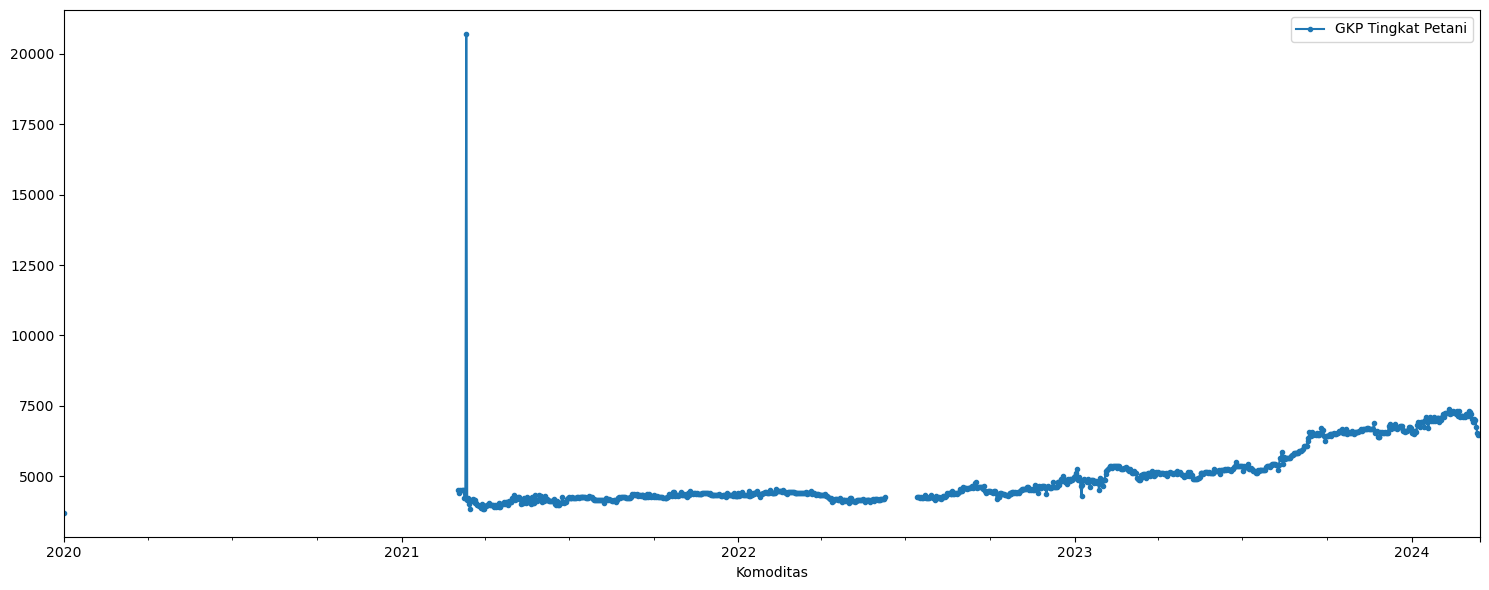

In [20]:
# plt.plot(df3)
df3[['GKP Tingkat Petani']].plot(style='.-', use_index=True)
# df3[['GKP Tingkat Petani']].loc['2020-01-01':'2024-03-01'].plot(style='.-')
plt.tight_layout()
plt.show()

In [21]:
# Clean dataset df3 from NaN
df3 = df3.dropna()
df3

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan,Beras,Beras Kualitas Bawah I,Beras Kualitas Medium I,Beras Kualitas Super I
Komoditas,,,,,,,,,,,,
2021-03-15,10,4000,4150,5050,8900,10030,20,10,11200,10100,11450,13100
2021-03-16,10,3850,4100,4740,8740,9980,70,20,11200,10100,11450,13100
2021-03-17,10,4160,4230,4950,8740,10060,30,10,11200,10100,11450,13100
2021-03-18,10,4120,4190,4730,8790,9890,40,10,11200,10050,11450,13100
2021-03-19,10,4190,4290,4990,8830,9990,40,10,11200,10100,11450,13100
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14180,15640,120,80,15800,14950,16050,17250
2024-03-12,10,6530,6930,8260,14140,15480,120,80,15800,14950,16050,17250
2024-03-13,10,6480,6920,8240,14040,15460,100,60,15750,14900,16000,17200


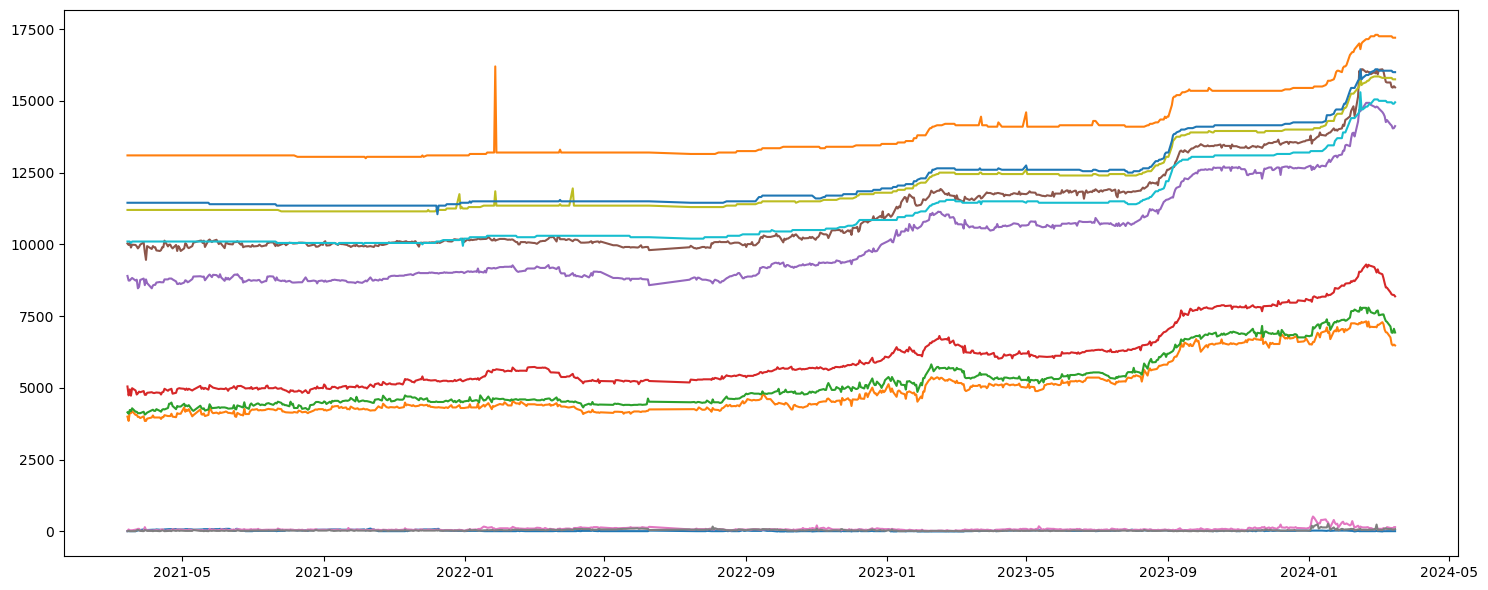

In [22]:
plt.plot(df3)
# df3[['GKP Tingkat Petani']].plot(style='.-', use_index=True)
# df3[['GKP Tingkat Petani']].loc['2020-01-01':'2024-03-01'].plot(style='.-')
plt.tight_layout()
plt.show()

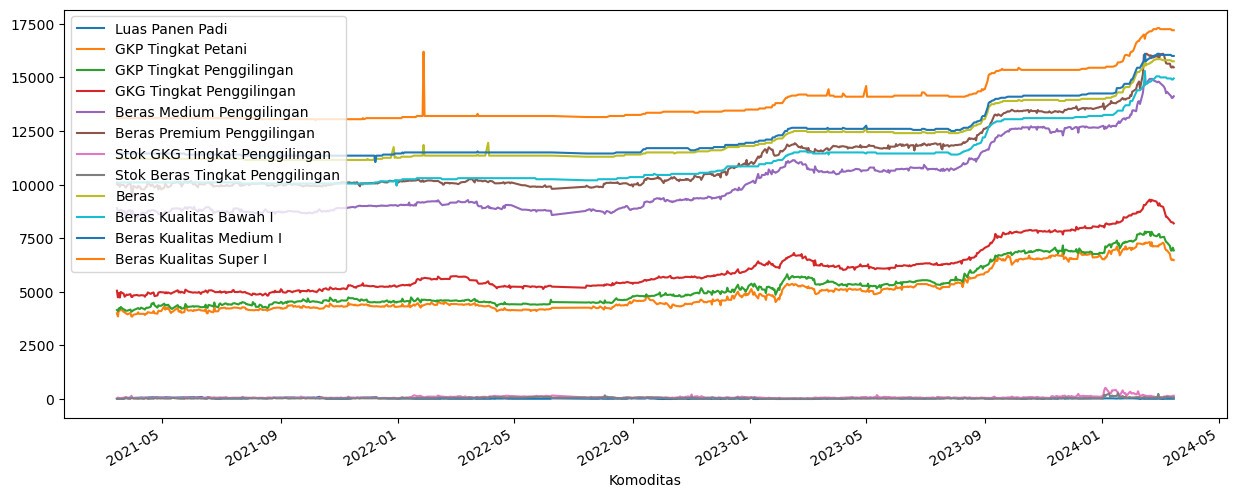

In [23]:
# Show me the column names of df3 in the plot above
df3.columns
import matplotlib.pyplot as plt

# Plot the dataframe
df3.plot()

# Show the column names
plt.legend(df3.columns)

# Display the plot
plt.show()


In [24]:
#Membuat fungsi untuk uji stasioneritas
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling( window=12).mean()
    rolstd = timeseries.rolling( window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()


    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

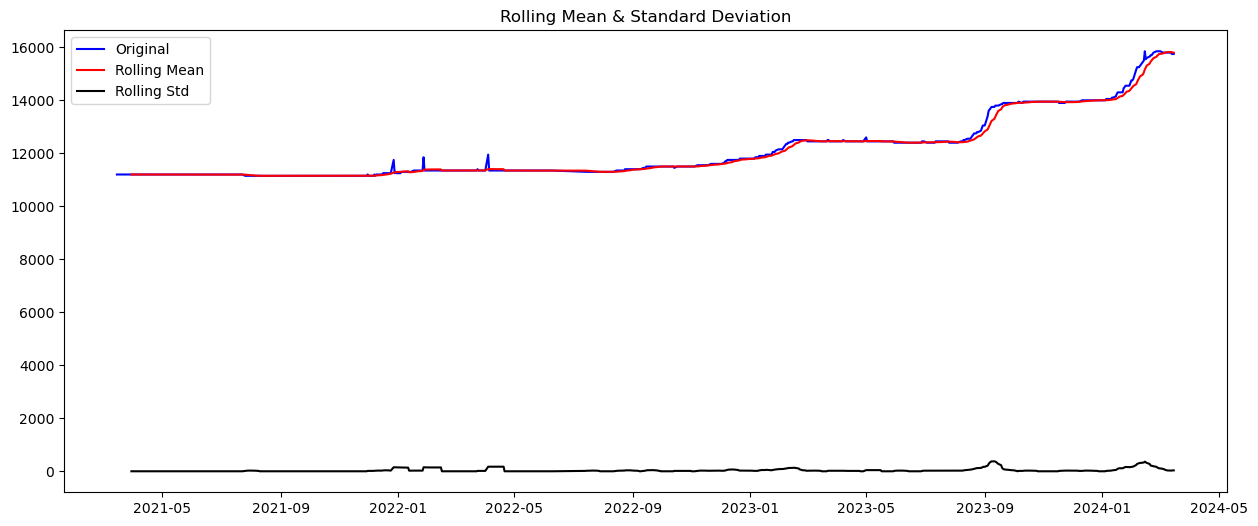

Results of Dickey-Fuller Test:
Test Statistic                   1.464749
p-value                          0.997389
#Lags Used                       8.000000
Number of Observations Used    724.000000
Critical Value (1%)             -3.439414
Critical Value (5%)             -2.865540
Critical Value (10%)            -2.568900
dtype: float64


In [25]:
#Menguji data
test_stationarity(df3['Beras'])

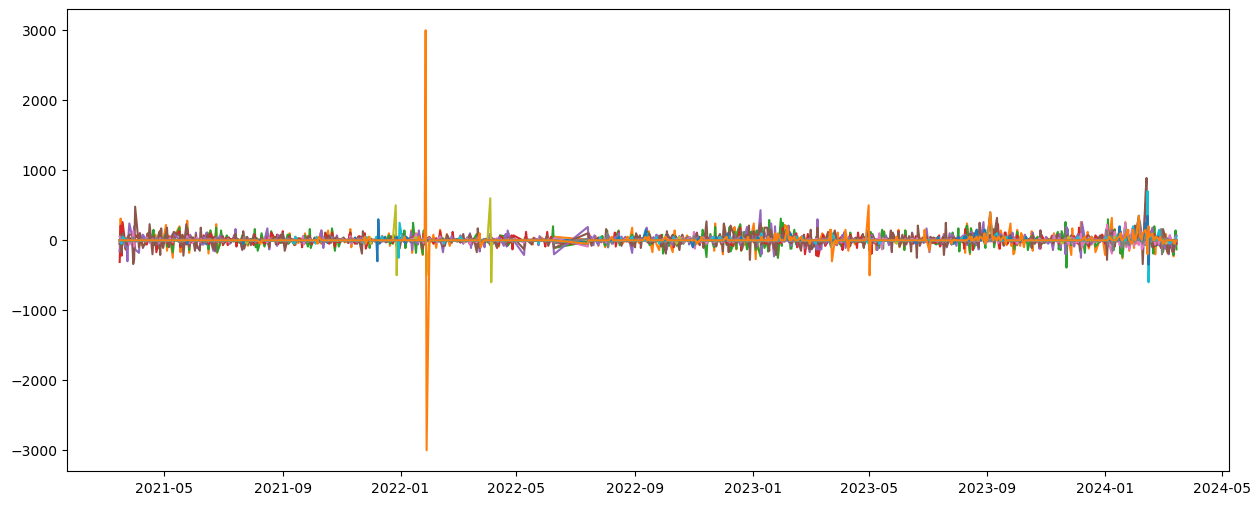

In [26]:
#Melakukan differencing pertama
df3_diff_1 = df3 - df3.shift()
df3_diff_1 = df3_diff_1.dropna()
plt.plot(df3_diff_1)

/Library/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:670: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/Library/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:670: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs2, **kwargs)


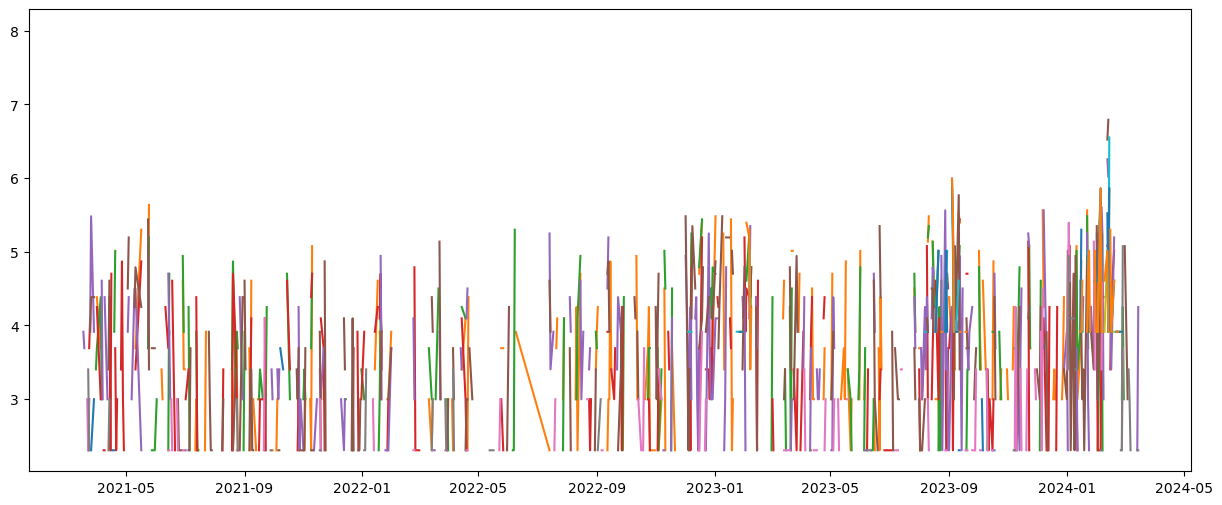

In [27]:
#Mencoba melakukan transformasi log
df3_log_dif = np.log(df3_diff_1)
plt.plot(df3_log_dif)

/Library/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:670: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs2, **kwargs)


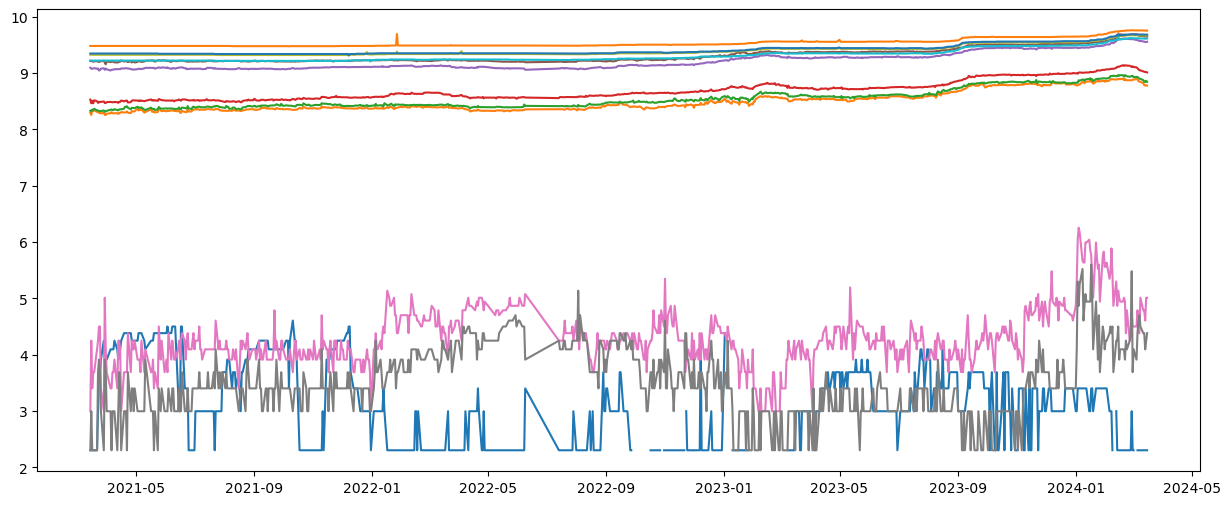

In [28]:
#Mencoba melakukan transformasi log
df3_log = np.log(df3)
plt.plot(df3_log)

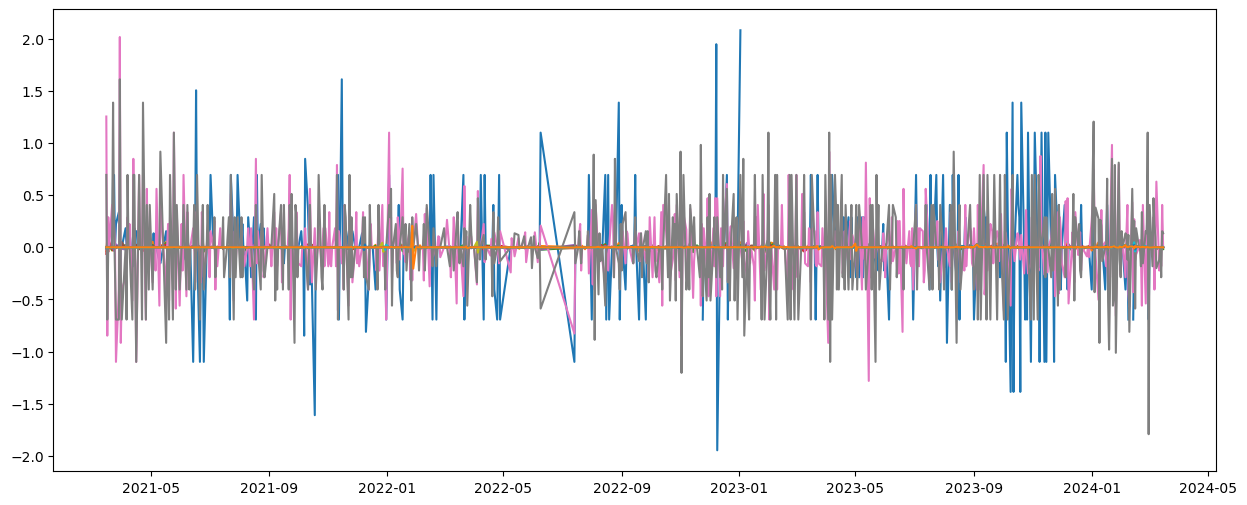

In [29]:
#Melakukan differencing setelah transform log
df3_log_1 = df3_log - df3_log.shift()
df3_log_1 = df3_log_1.dropna()
plt.plot(df3_log_1)

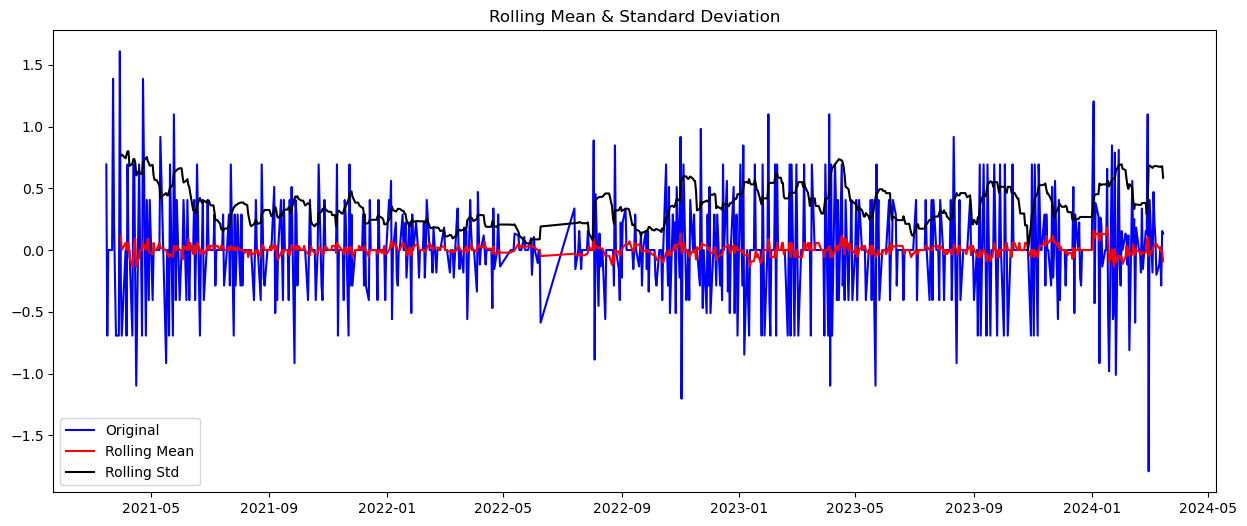

Results of Dickey-Fuller Test:
Test Statistic                -1.393318e+01
p-value                        5.045999e-26
#Lags Used                     7.000000e+00
Number of Observations Used    7.240000e+02
Critical Value (1%)           -3.439414e+00
Critical Value (5%)           -2.865540e+00
Critical Value (10%)          -2.568900e+00
dtype: float64


In [30]:
# Assuming 'column_name' is the name of the column in df3_log_1
test_stationarity(df3_log_1['Stok Beras Tingkat Penggilingan'])

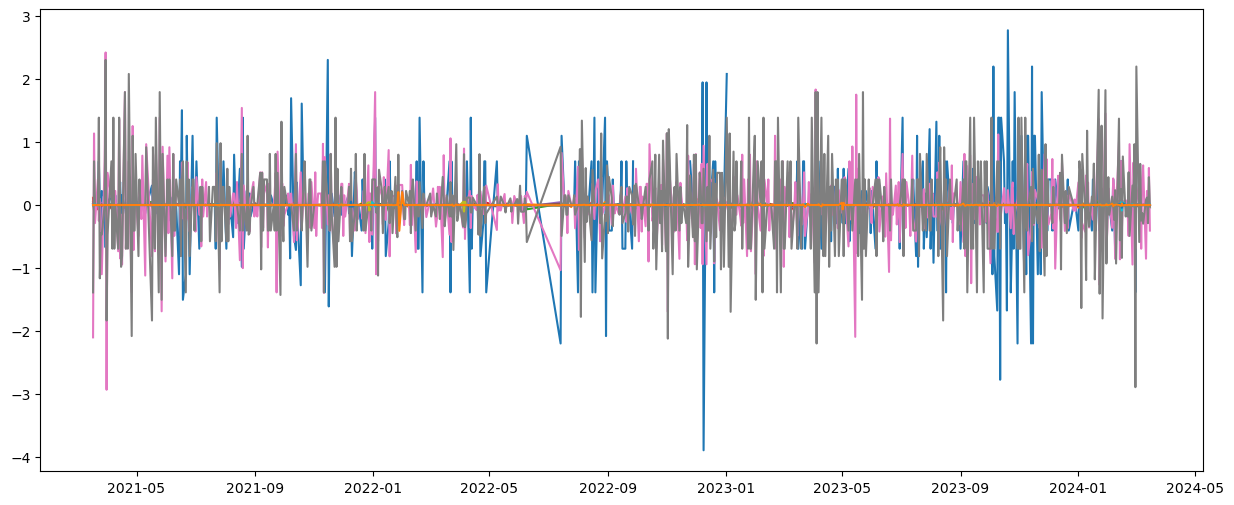

In [31]:
#Melakukan differencing kedua
df3_log_2 = df3_log_1 - df3_log_1.shift()
df3_log_2 = df3_log_2.dropna()
plt.plot(df3_log_2)

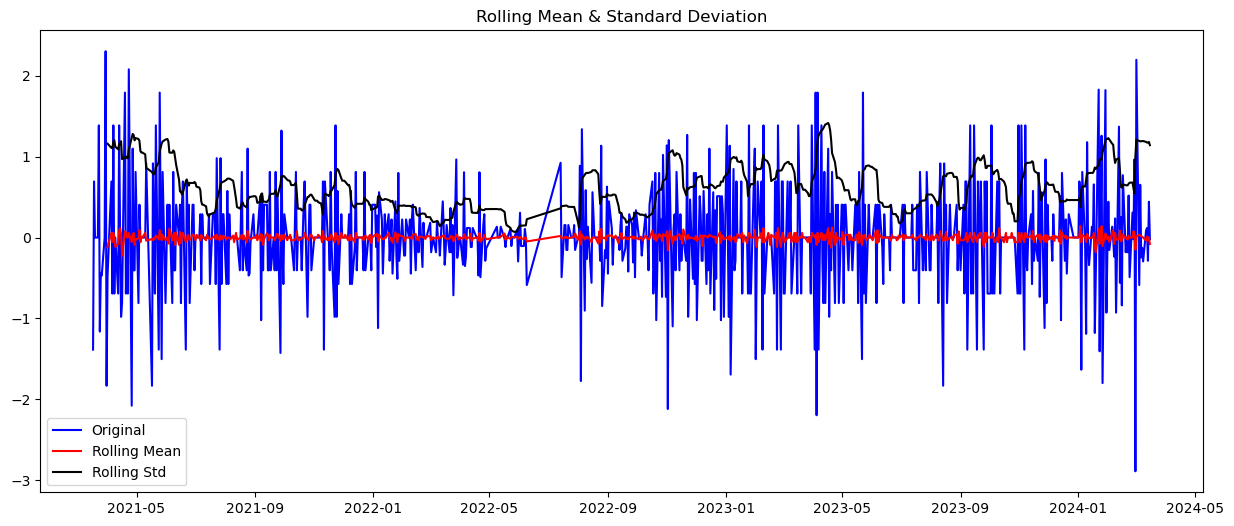

Results of Dickey-Fuller Test:
Test Statistic                -1.096788e+01
p-value                        8.017574e-20
#Lags Used                     2.000000e+01
Number of Observations Used    7.100000e+02
Critical Value (1%)           -3.439594e+00
Critical Value (5%)           -2.865619e+00
Critical Value (10%)          -2.568942e+00
dtype: float64


In [32]:
# Assuming 'column_name' is the name of the column in df3_log_2
test_stationarity(df3_log_2['Stok Beras Tingkat Penggilingan'])

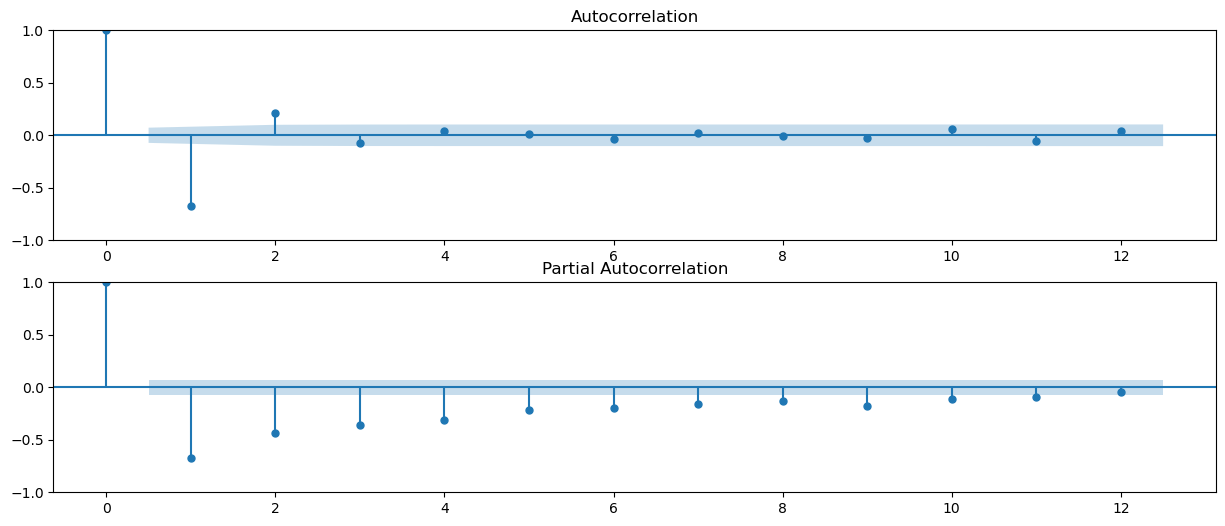

In [33]:
plt.figure()
plt.subplot(211)
plot_acf(df3_log_2['Stok Beras Tingkat Penggilingan'], ax=plt.gca(), lags=12)
plt.subplot(212)
plot_pacf(df3_log_2['Stok Beras Tingkat Penggilingan'], ax=plt.gca(), lags=12)
plt.show()

In [34]:
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.7)               #data trainingnya 70%
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [35]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df3_log['Stok GKG Tingkat Penggilingan'].values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


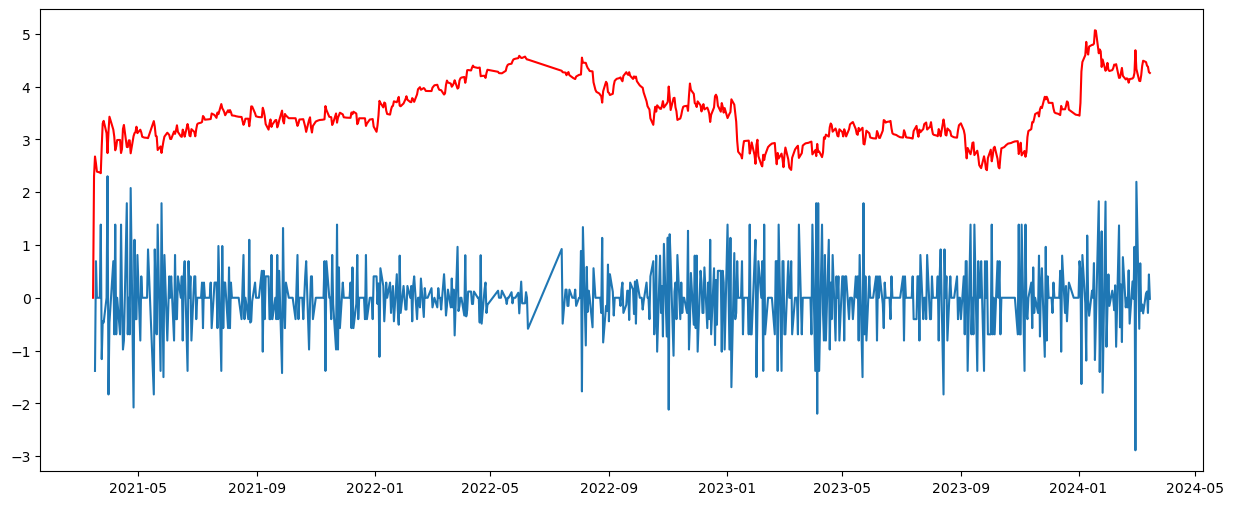

In [36]:
from statsmodels.tsa.arima.model import ARIMA

model_ARIMA = ARIMA(df3_log['Stok Beras Tingkat Penggilingan'], order=(2,1,1))
results_ARIMA = model_ARIMA.fit()
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
plt.plot(df3_log_2['Stok Beras Tingkat Penggilingan'])
plt.plot(predictions_ARIMA_diff, color='red')

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    results_ARIMA = model_ARIMA.fit()

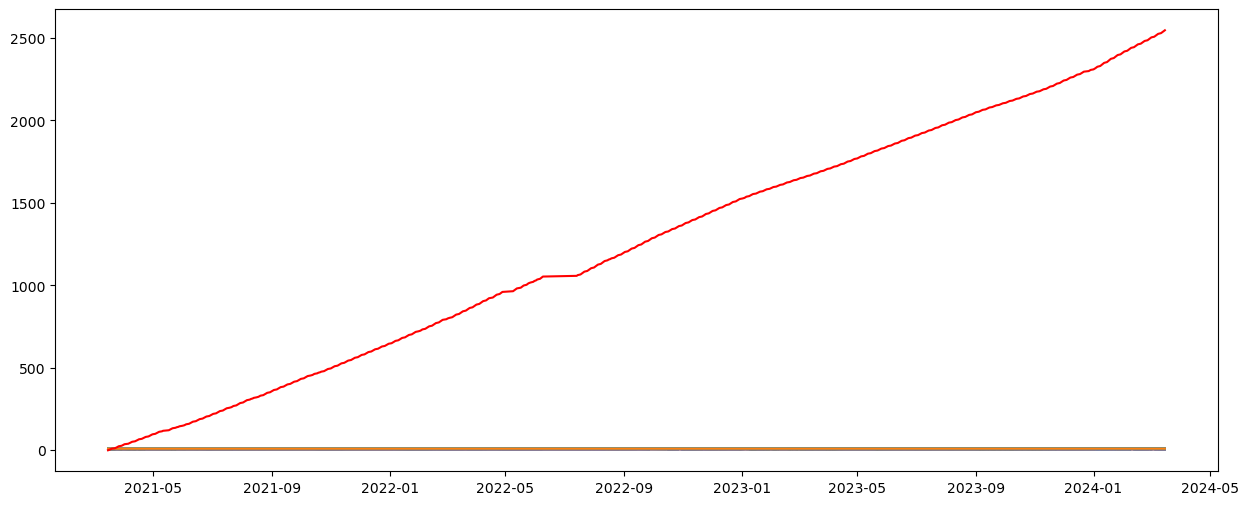

In [37]:
predictions_ARIMA_diff_cum_sum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df3_log.iloc[6],index=df3_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cum_sum,fill_value=0)
plt.plot(df3_log)
plt.plot(predictions_ARIMA_log, color='red')               #fitting dengan data yang ditransformasi log

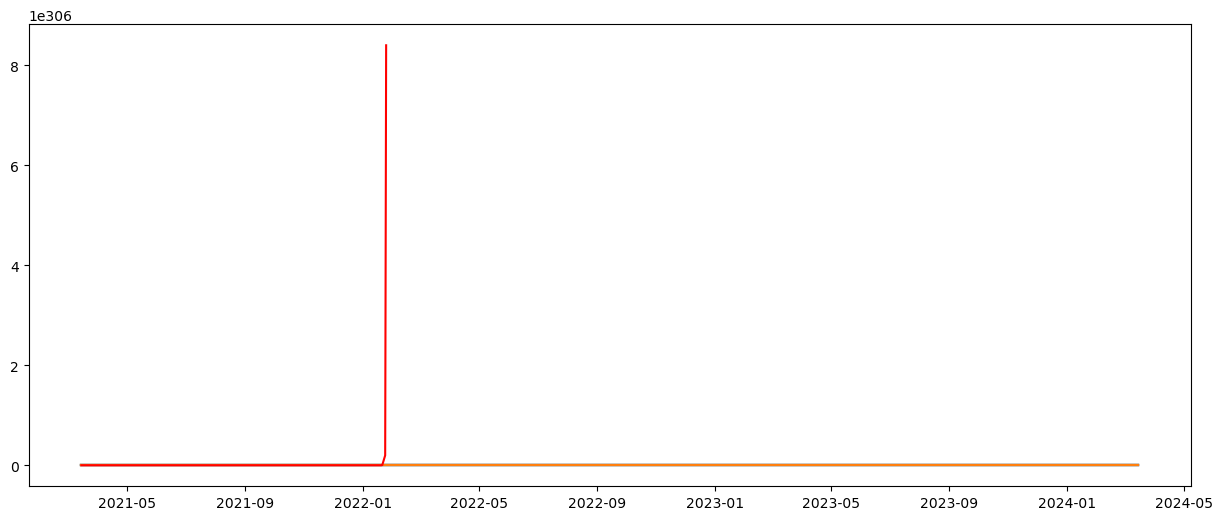

In [38]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df3)
plt.plot(predictions_ARIMA, color='red')                    #fitting dengan data asli

In [39]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:     Stok Beras Tingkat Penggilingan   No. Observations:                  733
Model:                              ARIMA(2, 1, 1)   Log Likelihood                -210.174
Date:                             Wed, 20 Mar 2024   AIC                            428.348
Time:                                     13:20:30   BIC                            446.732
Sample:                                          0   HQIC                           435.440
                                             - 733                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2090      0.040      5.255      0.000       0.131       0.287
ar.L2          0.1528      0.041      3.751      0.000       0.073       0.233
ma.L1         -0.8516      0.030    -27.947      0.000      -0.911      -0.792
sigma2         0.1039      0.004     26.973      0.000       0.096       0.111
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               134.11
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             0.31
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
train_size = int(len(df3) * 0.7)               #data trainingnya 70%
train, test = df3_log_2[:train_size], df3_log_2[train_size:]
history = [x for x in train['Stok Beras Tingkat Penggilingan']]
# make predictions
predictions = list()
for t in range(len(test)):
    model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,4))
    model_fit = model.fit(method='bfgs', maxiter=200)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test['Stok Beras Tingkat Penggilingan'].iloc[t])

# calculate out of sample error
rmse = sqrt(mean_squared_error(test['Stok Beras Tingkat Penggilingan'], predictions))
print(rmse)

Optimization terminated successfully.
         Current function value: 0.701022
         Iterations: 41
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.700112
         Iterations: 41
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.699343
         Iterations: 41
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.698994
         Iterations: 41
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.698875
         Iterations: 41
         Function evaluations: 44
         Gradient evaluations: 44
Optimization terminated successfully.
         Current function value: 0.698139
         Iterations: 41
         Function evaluations: 44
  

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     70      1     0     0   6.124D-04   7.182D-01
  F =  0.71815758056793100     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
0.5148244027324439

In [41]:
#explain the the result of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  730
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -524.250
Date:                           Wed, 20 Mar 2024   AIC                           1058.499
Time:                                   13:22:14   BIC                           1081.430
Sample:                                        0   HQIC                          1067.349
                                           - 730                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6759      0.025    -27.499      0.000      -0.724      -0.628
ma.L1         -1.0000     11.132     -0.090      0.928     -22.819      20.819
ar.S.L4        0.0356      0.031      1.137      0.256      -0.026       0.097
ma.S.L4       -1.0000     15.006     -0.067      0.947     -30.412      28.412
sigma2         0.2366      4.357      0.054      0.957      -8.304       8.777
===================================================================================
Ljung-Box (L1) (Q):                  58.97   Jarque-Bera (JB):                76.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.11
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

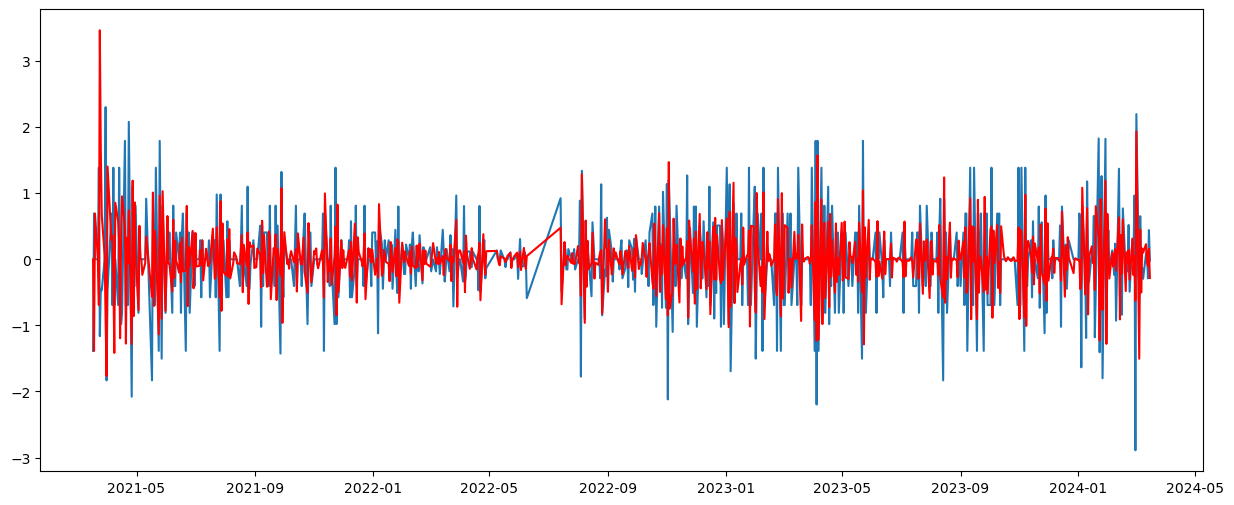

In [42]:
#Bikin model SARIMA
model_sarima = SARIMAX(df3_log_2['Stok Beras Tingkat Penggilingan'], order=(1,1,1), seasonal_order=(1,1,1,4))
results_SARIMA = model_sarima.fit(disp=-1)
predictions_SARIMA_diff = pd.Series(results_SARIMA.fittedvalues,copy=True)
plt.plot(df3_log_2['Stok Beras Tingkat Penggilingan'])
plt.plot(predictions_SARIMA_diff, color='red')               #fitting dengan data log

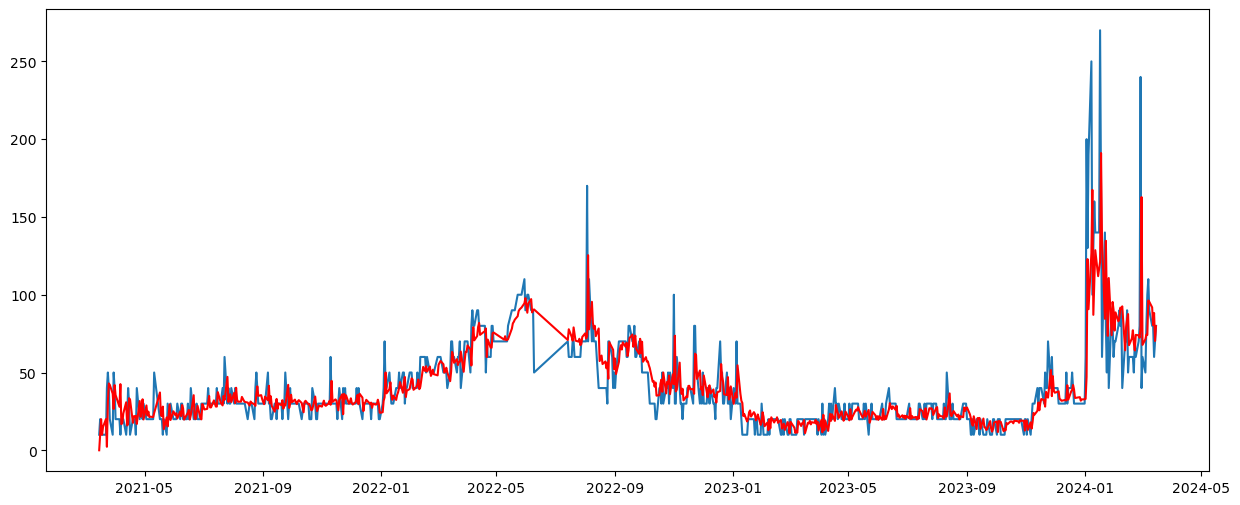

In [43]:
#SARIMA + trend untuk data asli
model_sarima_trend = SARIMAX(df3['Stok Beras Tingkat Penggilingan'], order=(1,1,1), seasonal_order=(1,1,1,4), trend='t')
results_SARIMA_t = model_sarima_trend.fit(disp=-1)
predictions_SARIMA_diff_t = pd.Series(results_SARIMA_t.fittedvalues,copy=True)
plt.plot(df3['Stok Beras Tingkat Penggilingan'])
plt.plot(predictions_SARIMA_diff_t, color='red')               #fitting dengan data

In [44]:
results_SARIMA_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:     Stok Beras Tingkat Penggilingan   No. Observations:                  733
Model:               SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood               -3213.065
Date:                             Wed, 20 Mar 2024   AIC                           6438.131
Time:                                     13:22:15   BIC                           6465.672
Sample:                                          0   HQIC                          6448.758
                                             - 733                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       6.245e-07    7.7e-06      0.081      0.935   -1.45e-05    1.57e-05
ar.L1          0.4676      0.030     15.667      0.000       0.409       0.526
ma.L1         -0.9397      0.014    -65.907      0.000      -0.968      -0.912
ar.S.L4        0.0288      0.055      0.527      0.598      -0.078       0.136
ma.S.L4       -0.9759      0.031    -31.532      0.000      -1.037      -0.915
sigma2       637.5037     20.296     31.410      0.000     597.724     677.283
===================================================================================
Ljung-Box (L1) (Q):                  12.06   Jarque-Bera (JB):             28107.14
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.24   Skew:                             2.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
#dengan model ARIMA
predict_dif = results_ARIMA.predict(start=144,end=156)
predictions_dif_cum_sum = predict_dif.cumsum()                   #prediksi differencingnya
pred_log = [df3_log_2['Stok Beras Tingkat Penggilingan'].iloc[-1]]
for i, j in enumerate(predictions_dif_cum_sum):                  #prediksi data lognya
  a = pred_log[i] + j
  pred_log.append(a)
predict_exp = pd.Series(np.exp(pred_log[1:]), index=predict_dif.index)  #prediksi data aslinya
print(predict_exp)

Komoditas
2021-10-15     2.871092e+01
2021-10-18     2.474872e+04
2021-10-19     6.292750e+08
2021-10-21     4.093291e+14
2021-10-22     6.172739e+21
2021-10-25     2.704660e+30
2021-10-26     3.621828e+40
2021-10-27     1.223797e+52
2021-10-28     9.474876e+64
2021-10-29     1.904077e+79
2021-11-01     1.079640e+95
2021-11-02    1.743048e+112
2021-11-03    8.074988e+130
dtype: float64


In [48]:
#prediksi dengan SARIMA+trend
pred_2 = results_SARIMA_t.predict()
print(pred_2)

Komoditas
2021-03-15     0.000001
2021-03-16     9.998219
2021-03-17    19.995969
2021-03-18    10.003183
2021-03-19    15.000761
                ...    
2024-03-11    91.842013
2024-03-12    80.465562
2024-03-13    88.252290
2024-03-14    70.284883
2024-03-15    79.784194
Name: predicted_mean, Length: 733, dtype: float64


In [47]:
df3

,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Beras Medium Penggilingan,Beras Premium Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan,Beras,Beras Kualitas Bawah I,Beras Kualitas Medium I,Beras Kualitas Super I
Komoditas,,,,,,,,,,,,
2021-03-15,10,4000,4150,5050,8900,10030,20,10,11200,10100,11450,13100
2021-03-16,10,3850,4100,4740,8740,9980,70,20,11200,10100,11450,13100
2021-03-17,10,4160,4230,4950,8740,10060,30,10,11200,10100,11450,13100
2021-03-18,10,4120,4190,4730,8790,9890,40,10,11200,10050,11450,13100
2021-03-19,10,4190,4290,4990,8830,9990,40,10,11200,10100,11450,13100
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-11,10,6760,7140,8330,14180,15640,120,80,15800,14950,16050,17250
2024-03-12,10,6530,6930,8260,14140,15480,120,80,15800,14950,16050,17250
2024-03-13,10,6480,6920,8240,14040,15460,100,60,15750,14900,16000,17200
